## Application to the analysis of the US supreme Court

In [173]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from scipy.stats import linregress


sns.set(style="whitegrid")
plt.rc('text')
plt.rc('font', family='serif')
LABELSIZE = 21
TICKSIZE = 19


In [78]:
spike_times = np.loadtxt(r'..\data\US_SupremeCourt_n9_N895.txt')
pandas_spikes = pd.read_csv(r'..\data\US_SupremeCourt_n9_N895.txt')

# intervals = np.diff(spike_times)
# print(f"Number of spikes: {len(spike_times)}")
# print(f"Number of intervals: {len(intervals)}")
# print(f"Range of spike times: {spike_times[0]} to {spike_times[-1]} ms")
# print(f"Min interval: {np.min(intervals):.3f} ms")
# print(f"Max interval: {np.max(intervals):.3f} ms")
# print(f"Mean interval: {np.mean(intervals):.3f} ms")

# # Plot the distribution of interspike intervals
# plt.figure(figsize=(10, 6))
# hist, bins, _ = plt.hist(intervals, bins=50, density=True, alpha=0.7, 
#                          color='skyblue', edgecolor='black')
# plt.xlabel('Inter-spike Interval τ (ms)')
# plt.ylabel('Probability Density P(τ)')
# plt.title('Distribution of Inter-spike Intervals')
# plt.savefig('..\\results\\neuron_model\\interspike_intervals.pdf', dpi=300, bbox_inches='tight')\
    

In [79]:
# Convert the np array to a list of strings
vote_patterns = []
for value in spike_times:
    str_value = str(int(value))
    if value == 0:
        pattern = "000000000"
    else:
        # pad with zeros to ensure each string is 9 characters long
        if len(str_value) < 9:
            pattern = str_value.zfill(9)
        else:
            pattern = str_value[-9:]
    vote_patterns.append(pattern)
    
# Count unique patterns
unique_patterns = set(vote_patterns)
N_max = len(unique_patterns)
print(f"Number of unique voting patterns (N_max): {N_max}")

Number of unique voting patterns (N_max): 128


In [95]:
judge_names = ['JS', 'RG', 'DS', 'SB', 'SO', 'AK', 'WR', 'AS', 'CT']
df = pd.DataFrame([list(pattern) for pattern in vote_patterns], 
                  columns=judge_names)

# Convert string values to integers
df = df.astype(int)
# Map 0s to -1s to match the paper's representation
df = df.replace(0, -1)
avg_votes = df.mean()


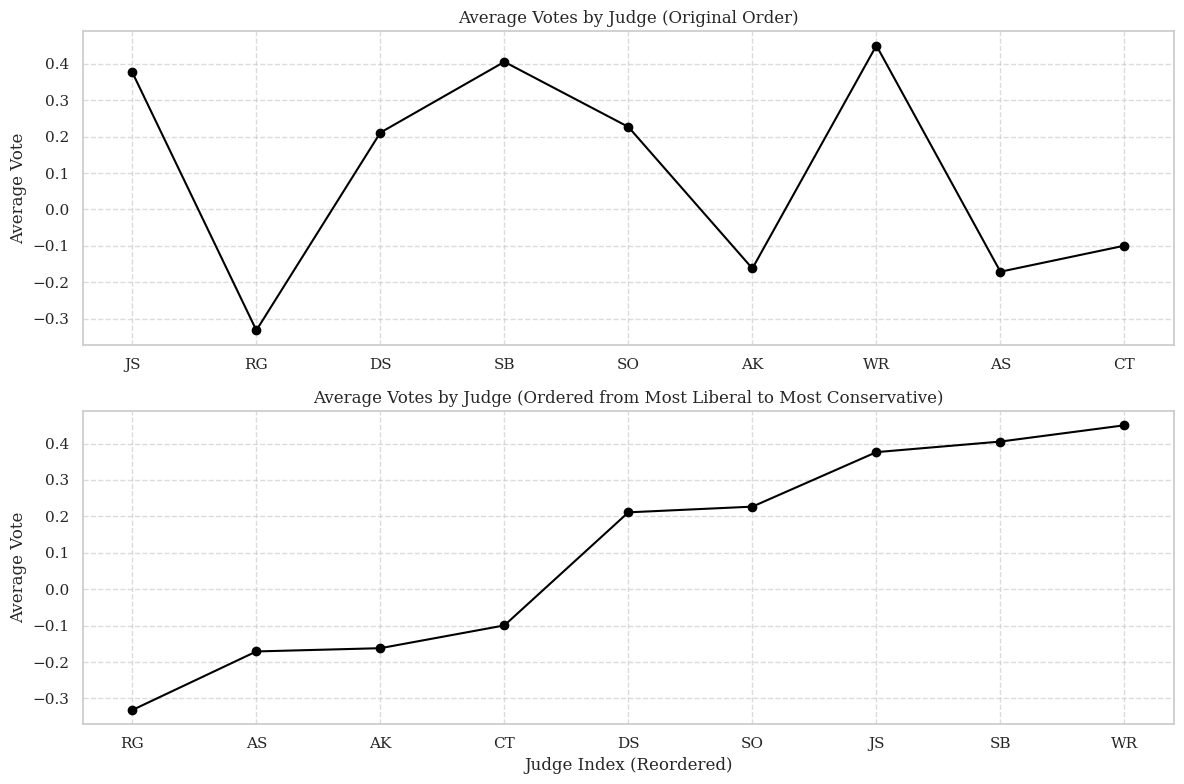

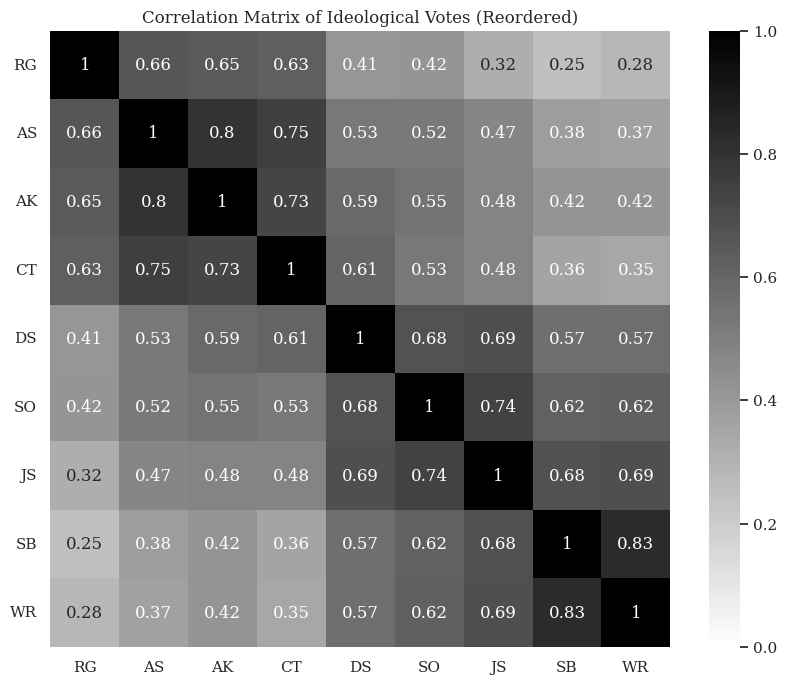

In [ ]:
judge_indices = np.arange(1, 10)

# Plot the average votes (before reordering)
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(judge_indices, avg_votes.values, 'o-', color='black')
plt.ylabel('Average Vote')
plt.title('Average Votes by Judge (Original Order)')
plt.xticks(judge_indices, judge_names)
plt.grid(True, linestyle='--', alpha=0.7)
# Reorder indices by average votes (smallest to largest)
reordered_indices = avg_votes.sort_values().index
avg_votes_reordered = avg_votes[reordered_indices]
reordered_names = [judge_names[judge_names.index(i)] for i in reordered_indices]

# Plot the reordered average votes
plt.subplot(212)
plt.plot(judge_indices, avg_votes_reordered.values, 'o-', color='black')
plt.ylabel('Average Vote')
plt.xlabel('Judge Index (Reordered)')
plt.title('Average Votes by Judge (Ordered from Most Liberal to Most Conservative)')
plt.xticks(judge_indices, reordered_names)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('..\\results\\us_court\\reordered.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix with the new ordering
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[reordered_indices, reordered_indices], 
            cmap='gray_r', vmin=0, vmax=1,annot=True)
plt.title('Correlation Matrix of Ideological Votes (Reordered)')
plt.xticks(np.arange(len(reordered_names))+0.5, reordered_names)
plt.yticks(np.arange(len(reordered_names))+0.5, reordered_names, rotation=0)
plt.savefig('..\\results\\us_court\\correlation_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
hi = np.loadtxt(r'..\data\hi_ussc_unsorted.txt')
jij = np.loadtxt(r'..\data\Jij_ussc_unsorted.txt')

hi_df = pd.DataFrame({'Judge': judge_names, 'h_i': hi})
# From smallest to largest average vote
reordered_indices = ['RG', 'AS', 'AK', 'CT', 'DS', 'SO', 'JS', 'SB', 'WR']
# Reorder the h_i values
hi_reordered = [hi_df.loc[hi_df['Judge'] == judge, 'h_i'].values[0] for judge in reordered_indices]

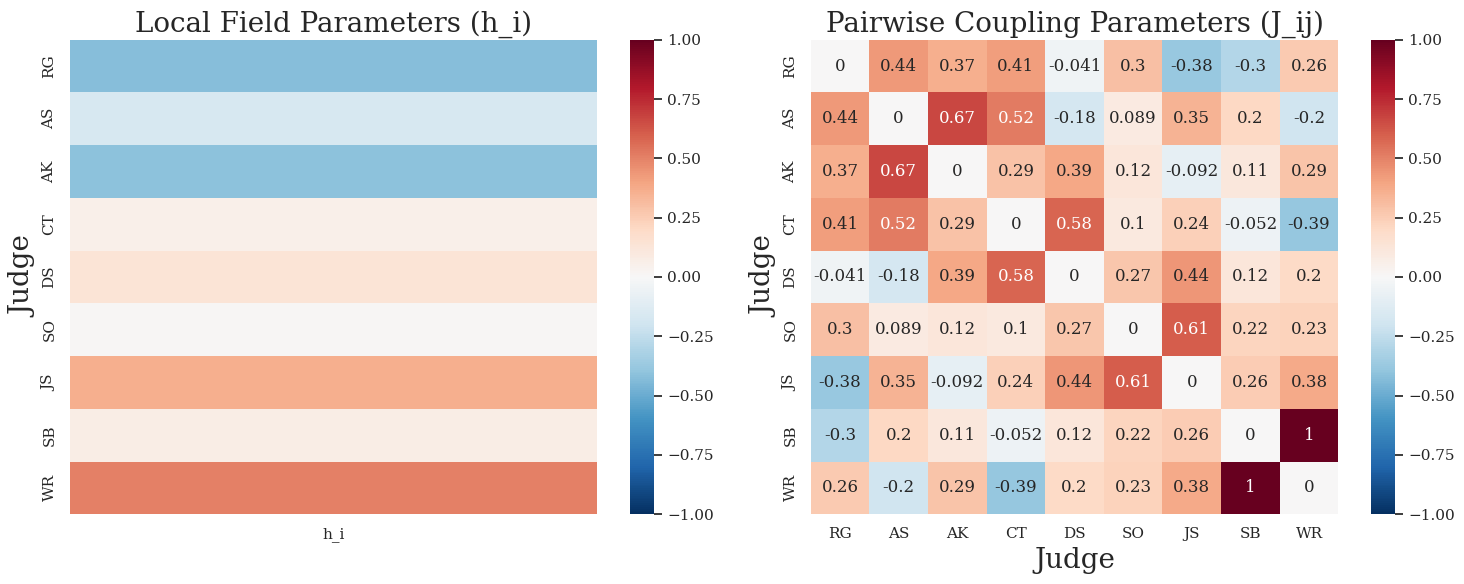

In [145]:
# Initialize a 9x9 matrix with zeros
J_matrix = np.zeros((9, 9))

# Fill the matrix with the provided J_ij values
idx = 0
for i in range(9):
    for j in range(i+1, 9):
        J_matrix[i, j] = jij[idx]
        J_matrix[j, i] = jij[idx]  # Symmetric matrix
        idx += 1
J_df = pd.DataFrame(J_matrix, index=judge_names, columns=judge_names)

# Reorder the J_ij matrix
J_reordered = J_df.loc[reordered_indices, reordered_indices]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot h_i heatmap
sns.heatmap(pd.DataFrame(hi_reordered, index=reordered_indices, columns=['h_i']), 
            cmap='RdBu_r', center=0, ax=axs[0], vmin=-1, vmax=1)
axs[0].set_title('Local Field Parameters (h_i)', fontsize=20)
axs[0].set_ylabel('Judge',fontsize=20)


# Plot J_ij heatmap
sns.heatmap(J_reordered, cmap='RdBu_r', vmin=-1, vmax=1.0, ax=axs[1],annot=True)
axs[1].set_title('Pairwise Coupling Parameters (J_ij)', fontsize=20)
axs[1].set_xlabel('Judge', fontsize=20)
axs[1].set_ylabel('Judge', fontsize=20)

plt.tight_layout()
plt.savefig('..\\results\\us_court\\another_correlation.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Q.6.5

In [150]:
# Dictionary to store the counts of each pattern
pattern_counts = {}
for pattern in vote_patterns:
    if pattern in pattern_counts:
        pattern_counts[pattern] += 1
    else:
        pattern_counts[pattern] = 1

# Convert to empirical probabilities (p_D)
total_cases = len(vote_patterns)
p_D = {pattern: count/total_cases for pattern, count in pattern_counts.items()}

In [152]:
# Calculate model probabilities (p_g) using the fitted parameters
# p_g(s) = (1/Z) * exp(∑ h_i*s_i + ∑ J_ij*s_i*s_j)

def calculate_energy(state, h_values, J_matrix):
    # Convert state string to array of -1 and 1
    state_array = np.array([1 if s == '1' else -1 for s in state])
    
    # Calculate ∑ h_i*s_i
    h_term = np.sum(h_values * state_array)
    
    # Calculate ∑ J_ij*s_i*s_j
    J_term = 0
    for i in range(len(state_array)):
        for j in range(i+1, len(state_array)):
            J_term += J_matrix[i, j] * state_array[i] * state_array[j]
    
    return h_term + J_term


In [ ]:
energies = {pattern: calculate_energy(pattern, hi, J_matrix) for pattern in pattern_counts.keys()}
Z = np.sum([np.exp(energy) for energy in energies.values()])
p_g = {pattern: np.exp(energy)/Z for pattern, energy in energies.items()}

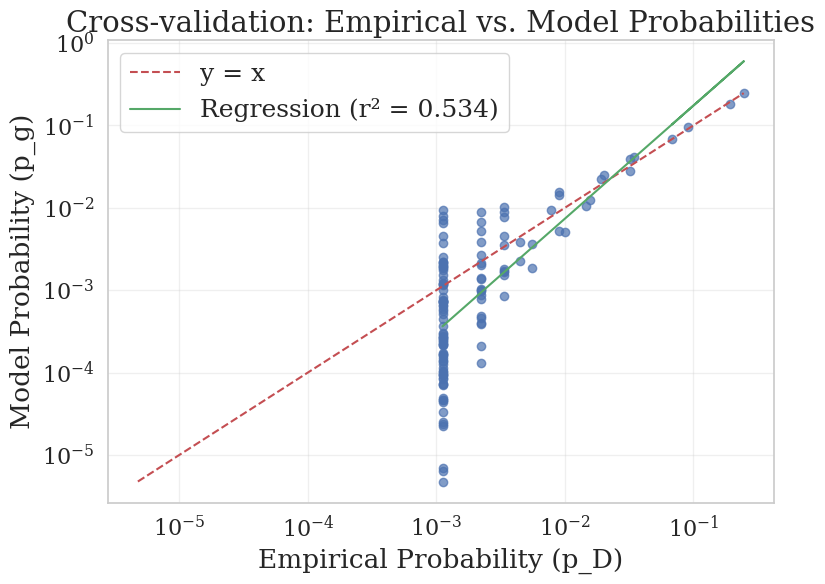

In [176]:
plt.figure(figsize=(8, 6))
plt.scatter(list(p_D.values()), list(p_g.values()), alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Empirical Probability (p_D)',fontsize=TICKSIZE)
plt.ylabel('Model Probability (p_g)',fontsize=TICKSIZE)
plt.title('Cross-validation: Empirical vs. Model Probabilities', fontsize=LABELSIZE)
plt.xticks(fontsize=TICKSIZE-3)
plt.yticks(fontsize=TICKSIZE-3)

# Add unity line
max_val = max(max(p_D.values()), max(p_g.values()))
min_val = min(min(p_D.values()), min(p_g.values()))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

# Add regression line
x = list(p_D.values())
y = list(p_g.values())
slope, intercept, r_value, p_value, std_err = linregress(np.log10(x), np.log10(y))
plt.plot(x, [10**(intercept) * (xi**slope) for xi in x], 'g-', label=f'Regression (r² = {r_value**2:.3f})')
plt.legend(fontsize=LABELSIZE-3, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('..\\results\\us_court\\cross-validation.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Q6.6

In [ ]:
# Calculate ⟨si⟩D from data
s_i_D = np.mean(df, axis=0)
# Calculate ⟨si⟩ from model
# These would be calculated based on the fitted model parameters
s_i_model = np.zeros(9)
for pattern, prob in p_g.items():
    state_array = np.array([1 if s == '1' else -1 for s in pattern])
    s_i_model += prob * state_array

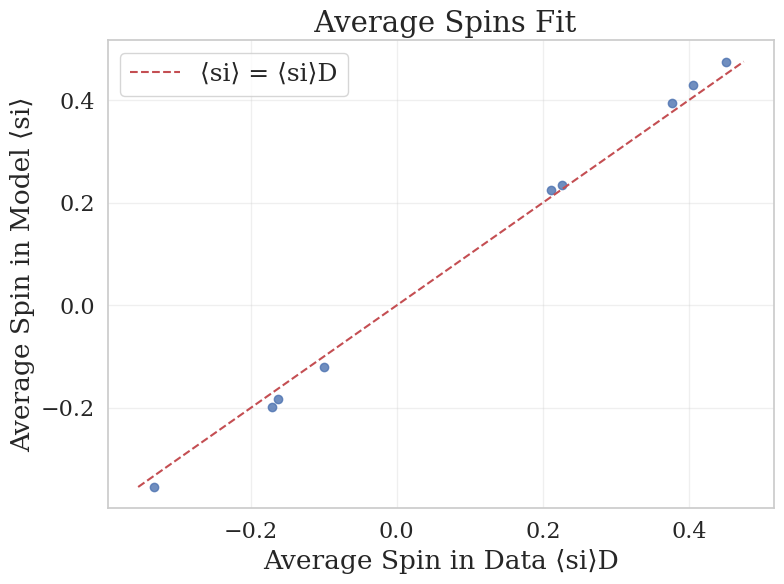

In [200]:
plt.figure(figsize=(8, 6))
plt.scatter(s_i_D, s_i_model, alpha=0.8)
plt.xlabel('Average Spin in Data ⟨si⟩D',fontsize=TICKSIZE)
plt.ylabel('Average Spin in Model ⟨si⟩',fontsize=TICKSIZE)
plt.title(' Average Spins Fit',fontsize=LABELSIZE)
plt.xticks(fontsize=TICKSIZE-3)
plt.yticks(fontsize=TICKSIZE-3)


max_val = max(max(s_i_D), max(s_i_model))
min_val = min(min(s_i_D), min(s_i_model))
plt.plot([min_val, max_val], [min_val, max_val], 'r--',label='⟨si⟩ = ⟨si⟩D')
plt.legend(fontsize=LABELSIZE-3, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('..\\results\\us_court\\average_spins_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()


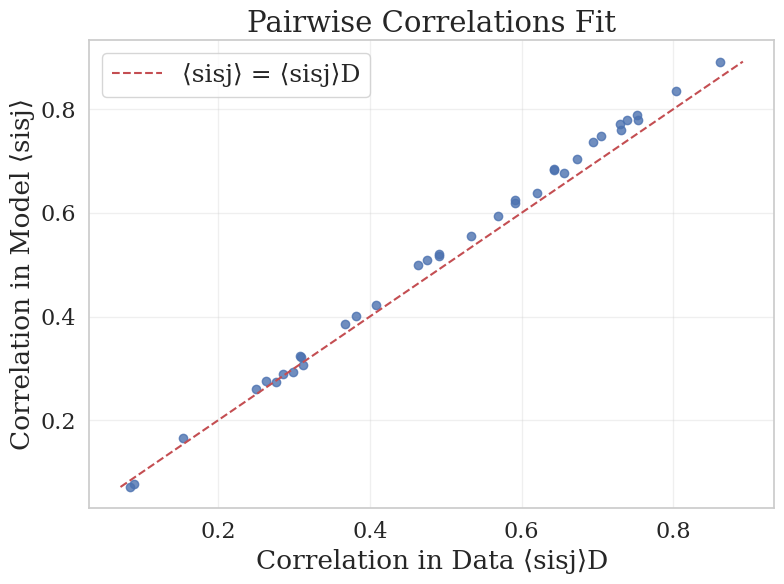

In [201]:
s_ij_D = []
s_ij_model = []
labels = []

for i in range(9):
    for j in range(i+1, 9):
        # Product of spins for each case
        prod = df.iloc[:, i] * df.iloc[:, j]
        # Average across all cases
        s_ij_D.append(np.mean(prod))
        
        # Calculate model correlation
        corr_model = 0
        for pattern, prob in p_g.items():
            state_array = np.array([1 if s == '1' else -1 for s in pattern])
            corr_model += prob * state_array[i] * state_array[j]
        
        s_ij_model.append(corr_model)
        labels.append(f'{judge_names[i]}-{judge_names[j]}')

plt.figure(figsize=(8, 6))
plt.scatter(s_ij_D, s_ij_model, alpha=0.8)
plt.xlabel('Correlation in Data ⟨sisj⟩D',fontsize=TICKSIZE)
plt.ylabel('Correlation in Model ⟨sisj⟩',fontsize=TICKSIZE)
plt.title('Pairwise Correlations Fit',fontsize=LABELSIZE)
plt.xticks(fontsize=TICKSIZE-3)
plt.yticks(fontsize=TICKSIZE-3)
max_val = max(max(s_ij_D), max(s_ij_model))
min_val = min(min(s_ij_D), min(s_ij_model))
plt.plot([min_val, max_val], [min_val, max_val], 'r--',label='⟨sisj⟩ = ⟨sisj⟩D')
plt.legend(fontsize=LABELSIZE-3, loc='upper left')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('..\\results\\us_court\\pairwise_spins_fit.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Q6.7

In [ ]:
p_i_plus_1 = (df.mean() + 1) / 2 # the data is in -1, 1 format so convert to 0, 1

print("Probability of conservative vote for each judge:")
for i, judge in enumerate(judge_names):
    print(f"{judge}: {p_i_plus_1[i]:.4f}")

# Count judges with conservative tendency (p_i > 0.5)
conservative_judges = sum(p_i_plus_1 > 0.5)
print(f"\nNumber of judges with conservative tendency: {conservative_judges}")
print(f"Number of judges with liberal tendency: {9 - conservative_judges}")

Probability of conservative vote for each judge:
JS: 0.6883
RG: 0.3341
DS: 0.6056
SB: 0.7028
SO: 0.6134
AK: 0.4190
WR: 0.7251
AS: 0.4145
CT: 0.4503

Number of judges with conservative tendency: 5
Number of judges with liberal tendency: 4


C:\Users\magggien\AppData\Local\Temp\ipykernel_11516\3030240388.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{judge}: {p_i_plus_1[i]:.4f}")
